In [1]:
import torch

from azula.guidance import MMPSDenoiser
from einops import rearrange, repeat
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lola.autoencoder import get_autoencoder
from lola.data import field_postprocess, field_preprocess, get_well_inputs, get_well_multi_dataset
from lola.diffusion import get_denoiser
from lola.emulation import decode_traj, emulate_diffusion, emulate_rollout, encode_traj
from lola.plot import draw_movie, plot_psd

torch.set_float32_matmul_precision("high")

device = torch.device("cuda")
rng = torch.manual_seed(0)

In [2]:
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/dm/cyqmbfjb_rayleigh_benard_f32c4_vit_large/")  # fmt: off
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/dm/667t8kzm_rayleigh_benard_f32c16_vit_large/")  # fmt: off
# runpath = Path("/mnt/ceph/users/frozet/lola/runs/dm/zt8nzq37_rayleigh_benard_f32c32_vit_large/")  # fmt: off
runpath = Path("/mnt/ceph/users/frozet/lola/runs/dm/0fqjt3js_rayleigh_benard_f32c64_vit_large/")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
cfg.ae = OmegaConf.load(runpath / "autoencoder/config.yaml").ae

## Data

In [3]:
dataset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="valid",
    steps=-1,
    include_filters=cfg.dataset.include_filters,
    augment=["log_scalars"],
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

postprocess = partial(
    field_postprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = get_autoencoder(**cfg.ae)
autoencoder.load_state_dict(torch.load(runpath / "autoencoder/state.pth", weights_only=True, map_location=device))
autoencoder.to(device)
autoencoder.requires_grad_(False)
autoencoder.eval()

AutoEncoder(
  (encoder): DCEncoder(
    (patch): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=1, w=1)
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): SiLU()
            (2): Dropout(p=0.05, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=2, w=2)
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(128, 128

## Denoiser

In [5]:
denoiser = get_denoiser(**cfg.denoiser)
denoiser.load_state_dict(torch.load(runpath / "state.pth", weights_only=True, map_location=device))
denoiser.to(device)
denoiser.requires_grad_(False)
denoiser.eval()

ElucidatedDenoiser(
  (backbone): EmbeddingWrapper(
    (backbone): ViT(
      (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=1, w=1)
      (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=1, w=1)
      (in_proj): Linear(in_features=128, out_features=1024, bias=True)
      (out_proj): Linear(in_features=1024, out_features=64, bias=True)
      (positional_embedding): Sequential(
        (0): SineEncoding()
        (1): Rearrange('... N C -> ... (N C)')
        (2): Linear(in_features=3072, out_features=1024, bias=True)
      )
      (blocks): ModuleList(
        (0-15): 16 x ViTBlock(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=False)
          (ada_zero): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): SiLU()
            (2): Linear(in_features=256, out_features=4096, bias=True)
            (3): Rearrange('... (n C) -> n ... 1 C', n=4)
          )
        

In [6]:
sum(p.numel() for p in denoiser.parameters())

222888512

## Emulation

In [7]:
x, label = get_well_inputs(dataset[158], device=device)
x = x[16 :: cfg.trajectory.stride]
x = rearrange(x, "L H W C -> C L H W")
x = preprocess(x, dim=0)

with torch.no_grad():
    z = encode_traj(autoencoder, x)

x_gt = postprocess(x, dim=0)

In [8]:
def emulate(mask, y, i):
    return emulate_diffusion(denoiser, mask, y, label=label, algorithm="ab", steps=16)


with torch.no_grad():
    z_hat = emulate_rollout(
        emulate,
        z,
        window=cfg.trajectory.length,
        rollout=z.shape[1],
        context=1,
        overlap=1,
    )

    x_hat = decode_traj(autoencoder, z_hat)

x_hat = postprocess(x_hat, dim=0)

In [9]:
frames = torch.stack((x_gt.mT, x_hat.mT))
frames = rearrange(frames, "N C L H W -> L N C H W")

draw_movie(frames, isolate={2}, fps=1.0, display=True, embed=True)

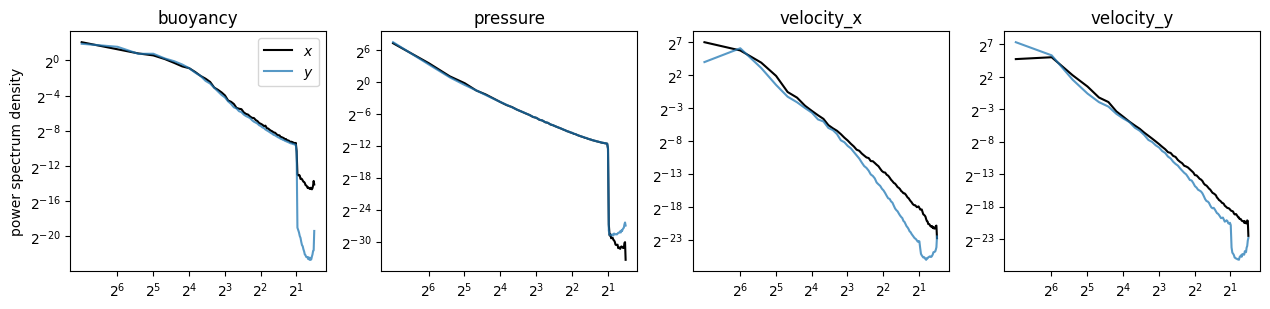

In [10]:
fig = plot_psd(x_gt[:, 16], x_hat[:, 16], fields=cfg.dataset.fields)

## Guidance

In [11]:
def D(z):
    with torch.nn.attention.sdpa_kernel(torch.nn.attention.SDPBackend.MATH):
        return decode_traj(autoencoder, z, batched=True, noisy=False)


A = lambda x: x[..., ::32, ::32]
y = A(x)
y = y + 1e-1 * torch.randn_like(y)


def emulate(mask, x_obs, i):
    y_i = y[..., i + 1 : i + cfg.trajectory.length, :, :]
    A_i = lambda z: A(D(z[..., 1 : 1 + len(y_i), :, :]))

    cond_denoiser = MMPSDenoiser(
        denoiser,
        y=y_i,
        A=A_i,
        var_y=1e-2,
        iterations=1,
    )

    return emulate_diffusion(cond_denoiser, mask, x_obs, label=label, algorithm="ab", steps=16)


with torch.no_grad():
    z_hat = emulate_rollout(
        emulate,
        z,
        window=cfg.trajectory.length,
        rollout=z.shape[1],
        context=1,
        overlap=1,
    )

    x_hat = decode_traj(autoencoder, z_hat)

x_hat = postprocess(x_hat, dim=0)

In [12]:
y = repeat(A(x_gt), "... H W -> ... (H h) (W w)", h=32, w=32)

frames = torch.stack((x_gt.mT, x_hat.mT, y.mT))
frames = rearrange(frames, "N C L H W -> L N C H W")

draw_movie(frames, isolate={2}, fps=1.0, display=True, embed=True)

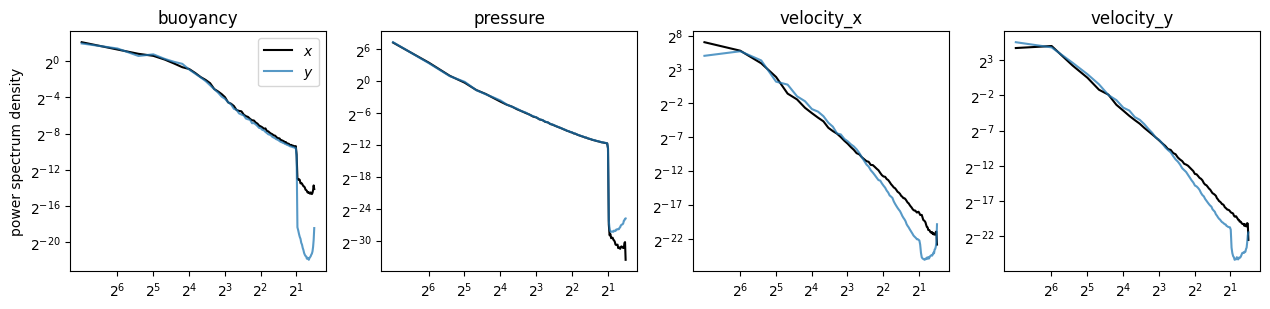

In [13]:
fig = plot_psd(x_gt[:, 16], x_hat[:, 16], fields=cfg.dataset.fields)